# Making and Evaluating patient embeddings

What will we do:
- collect and observe patients data
- use an LLM model to embed the medical information into a vector
- evaluate the predictive power of the embeddings
- filter the most predictive ones

In [6]:
import pandas as pd
import umap
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import shap
import torch
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from transformers import AutoTokenizer, AutoModel
from LabData.DataLoaders.SubjectLoader import SubjectLoader
from LabData.DataLoaders.GutMBLoader import GutMBLoader
from LabData.DataLoaders.BodyMeasuresLoader import BodyMeasuresLoader
from LabData.DataLoaders.BloodTestsLoader import BloodTestsLoader
from LabData.DataLoaders.DietLoggingLoader import DietLoggingLoader
from LabData.DataLoaders.CGMLoader import CGMLoader
from LabData.DataLoaders.UltrasoundLoader import UltrasoundLoader
from LabData.DataLoaders.ABILoader import ABILoader
from LabData.DataLoaders.ItamarSleepLoader import ItamarSleepLoader
from LabData.DataLoaders.MedicalConditionLoader import MedicalConditionLoader
from LabData.DataLoaders.MedicalProceduresLoader import MedicalProceduresLoader
from LabData.DataLoaders.Medications10KLoader import Medications10KLoader
from LabData.DataLoaders.LifeStyleLoader import LifeStyleLoader
from LabData.DataLoaders.DemographicsLoader import DemographicsLoader
from LabData.DataLoaders.ECGTextLoader import ECGTextLoader
from LabData.DataLoaders.DEXALoader import DEXALoader
from LabData.DataLoaders.PRSLoader import PRSLoader
from LabData.DataLoaders.HormonalStatusLoader import HormonalStatusLoader
from LabData.DataLoaders.IBSTenkLoader import IBSTenkLoader
from LabData.DataLoaders.SerumMetabolomicsLoader import SerumMetabolomicsLoader
from LabData.DataLoaders.FamilyMedicalConditionsLoader import FamilyMedicalConditionsLoader
from LabData.DataLoaders.ChildrenLoader import ChildrenLoader
from LabData.DataLoaders.MentalLoader import MentalLoader
from LabData.DataLoaders.TimelineLoader import TimelineLoader
from LabData.DataLoaders.SubjectRelationsLoader import SubjectRelationsLoader
from LabData.DataLoaders.RetinaScanLoader import RetinaScanLoader
from LabData.DataLoaders.PAStepsLoader import PAStepsLoader

In [7]:
study_ids = [10, 1001, 1002]
SubjectLoader().get_data(study_ids=study_ids).df.head(3)

,,StudyTypeID,city,country,gender,month_of_birth,us_state,yob,StudyTypeID2,StudyTypeID3,StudyTypeID4,StudyTypeID5,StudyTypeID6,StudyTypeID7,StudyTypeID8,StudyTypeID9,age,tz
RegistrationCode,Date,,,,,,,,,,,,,,,,,
10K_1000028368,2020-03-22 08:26:05.077073,10.0,None,IL,1.0,9,None,1966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,Asia/Jerusalem
10K_1000273395,2020-03-05 20:53:54.399388,10.0,None,IL,1.0,3,None,1979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,Asia/Jerusalem
10K_1000633050,2021-06-21 14:23:50.372010,10.0,None,IL,0.0,7,None,1955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,Asia/Jerusalem


In [8]:
bm = BodyMeasuresLoader().get_data(study_ids=study_ids).df.join(BodyMeasuresLoader().get_data(study_ids=study_ids).df_metadata)

general_info = bm.reset_index().set_index('RegistrationCode')
general_info = general_info[~general_info['gender'].isna()]
general_info = general_info[~general_info['age'].isna()]

gender_dictionary = {1:'male', 0:'female'}

general_info.loc[:,'gender'] = general_info['gender'].fillna(0).map(gender_dictionary)

general_info.head(10)

/tmp/ipykernel_204641/1518352966.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['male' 'female' 'female' ... 'male' 'male' 'female']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  general_info.loc[:,'gender'] = general_info['gender'].fillna(0).map(gender_dictionary)


,Date,fingers_grip_left,sitting_blood_pressure_systolic,waist,bmr,dizziness,body_temperature,is_getting_period,lying_blood_pressure_diastolic,dominant_hand,...,gender,sitting_second_blood_pressure_pulse_rate,sitting_another_hand_blood_pressure_systolic,second_hand_grip_right,StudyTypeID9,sitting_second_blood_pressure_systolic,age,source_created_at,country,StudyTypeID7
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10K_1000942861,2021-12-13 07:09:38.954985,NaN,NaN,99.0,NaN,False,NaN,NaN,87.0,Right,...,male,NaN,NaN,NaN,NaN,NaN,54.0,2021-12-13 07:09:38.954985+00:00,IL,NaN
10K_1001201093,2021-08-26 07:39:21.411519,NaN,104.0,76.0,NaN,False,NaN,NaN,69.0,Right,...,female,NaN,NaN,NaN,NaN,NaN,42.0,2021-08-26 07:39:21.411519+00:00,IL,NaN
10K_1001201093,2023-09-12 10:23:05.534125,NaN,107.0,70.0,NaN,NaN,NaN,NaN,NaN,Right,...,female,74.0,108.0,75.0,NaN,107.0,44.0,2023-09-12 10:23:05.534125+00:00,IL,NaN
10K_1002033709,2022-08-03 07:20:01.044769,NaN,102.0,80.0,NaN,True,NaN,NaN,72.0,Right,...,female,69.0,NaN,NaN,NaN,100.0,43.0,2022-08-03 07:20:01.044769+00:00,IL,NaN
10K_1002087123,2019-12-04 11:53:40.350115,NaN,145.0,113.0,1805.0,False,36.9,Yes,89.0,Right,...,female,NaN,NaN,NaN,NaN,NaN,42.0,2019-12-04 11:53:40.350115+00:00,IL,NaN
10K_1002087123,2022-03-22 11:42:27.565348,NaN,129.0,106.0,NaN,False,NaN,NaN,84.0,Right,...,female,NaN,NaN,NaN,NaN,NaN,45.0,2022-03-22 11:42:27.565348+00:00,IL,NaN
10K_1002254441,2022-09-15 07:00:31.408388,NaN,107.0,90.0,NaN,False,NaN,NaN,69.0,Left,...,male,70.0,NaN,NaN,NaN,103.0,45.0,2022-09-15 07:00:31.408388+00:00,IL,NaN
10K_1002254441,2025-02-13 06:20:52.699166,NaN,128.0,95.0,NaN,NaN,NaN,NaN,NaN,Left,...,male,60.0,130.0,93.9,NaN,121.0,48.0,2025-02-13 06:20:52.699166+00:00,IL,NaN
10K_1003113258,2020-02-09 12:38:07.180299,NaN,144.0,52.0,1980.0,False,36.6,NaN,78.0,Right,...,male,NaN,NaN,NaN,NaN,NaN,49.0,2020-02-09 12:38:07.180299+00:00,IL,NaN


In [9]:
general_info = general_info.reset_index()
# Count the number of unique RegistrationCodes
unique_count = general_info['RegistrationCode'].nunique()

# Calculate the frequency for each unique RegistrationCode
frequency_series = general_info['RegistrationCode'].value_counts()

# Compute the average and median frequencies
average_frequency = frequency_series.mean()
median_frequency = frequency_series.median()

print("Unique RegistrationCodes:", unique_count)
print("Average frequency per RegistrationCode:", average_frequency)
print("Median frequency per RegistrationCode:", median_frequency)


Unique RegistrationCodes: 12226
Average frequency per RegistrationCode: 1.7416162277114347
Median frequency per RegistrationCode: 2.0


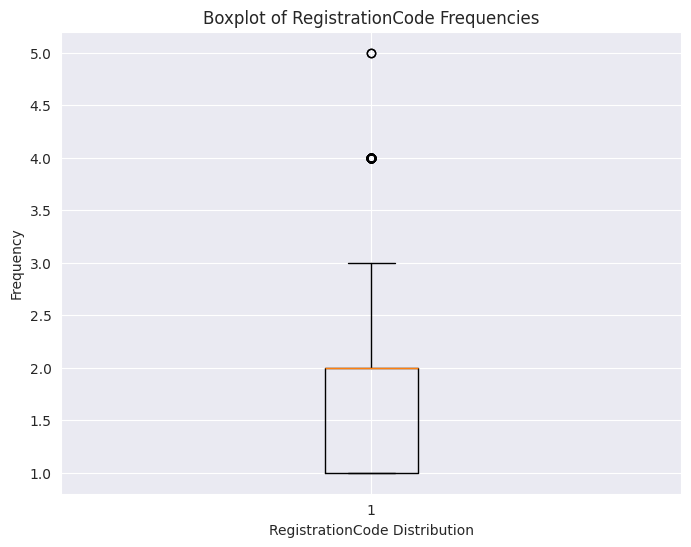

In [10]:
plt.figure(figsize=(8, 6))
plt.boxplot(frequency_series, vert=True)
plt.xlabel('RegistrationCode Distribution')
plt.ylabel('Frequency')
plt.title('Boxplot of RegistrationCode Frequencies')
plt.show()

In [11]:

# Count how many RegistrationCodes have frequencies of 1 through 5
frequency_counts = frequency_series.value_counts().reindex([1, 2, 3, 4, 5], fill_value=0)

# Display the results
for freq, count in frequency_counts.items():
    print(f"Number of RegistrationCodes with frequency {freq}: {count}")

Number of RegistrationCodes with frequency 1: 5298
Number of RegistrationCodes with frequency 2: 4873
Number of RegistrationCodes with frequency 3: 1973
Number of RegistrationCodes with frequency 4: 80
Number of RegistrationCodes with frequency 5: 2


### get the basleine and follow up conditions

In [12]:
path_file = '/net/mraid20/export/genie/LabData/Data/10K/for_review/'
file_name = 'follow_up_conditions_all.csv'
file_name_1 = 'baseline_conditions_all.csv'
full_path = path_file + file_name
full_path_1 = path_file + file_name_1

# Read the CSV file into a DataFrame
df_conditions_follow_up = pd.read_csv(full_path)
df_conditions_baseline = pd.read_csv(full_path_1)

# Display the first few rows of the DataFrame
df_conditions_baseline.head()

,RegistrationCode,medical_condition,Date,Start,name,created_at,research_stage,Group,Consolidated name,english_name,index,Baseline_Date
0,10K_1000942861,BlockL2-6A7,2008-01-01,True,דיכאון,2021-06-11 11:51:55,baseline,Neurologic,Depression,Depressive disorders,NaN,NaN
1,10K_1000942861,DB60,2000-01-01,True,טחורים,2021-06-11 11:51:55,baseline,Surgery,Haemorrhoids,Haemorrhoids,NaN,NaN
2,10K_1000942861,RA01,2020-12-23,True,קורונה,2023-12-25 12:52:12.534390+00:00,baseline,Infectious Disease,COVID-19,COVID-19,NaN,NaN
3,10K_1002033709,ED80,2000-01-01,True,אקנה,2022-01-11 07:16:11.594000,baseline,Dermatology,Allergy,Acne,NaN,NaN
4,10K_1002033709,GC08.Z,2000-01-01,True,דלקת בשתן,2022-01-11 07:16:11.594000,baseline,Urology,Urinary tract infection,"Urinary tract infection, site and agent not sp...",NaN,NaN


In [13]:
df_conditions_follow_up.head()

,RegistrationCode,medical_condition,index,Date,Start,name,created_at,research_stage,Group,Consolidated name,english_name,Baseline_Date
0,10K_1001201093,RA01,560,2022-05-01 00:00:00.000000,True,קורונה,2022-08-02 05:48:59.526988+00:00,01_00_call,Infectious Disease,COVID-19,COVID-19,2021-08-26 07:39:21.411519
1,10K_1002087123,DA63,562,2021-01-01 00:00:00.000000,True,כיב בתריסריון (DA63),2022-03-22 12:42:01.880301+00:00,02_00_visit,Gastro,Peptic Ulcer Disease,Duodenal ulcer,2019-12-04 11:53:40.350115
2,10K_1002087123,GB70,561,2021-01-01 00:00:00.000000,True,אבנים בכליות (GB70),2022-03-22 12:42:01.880301+00:00,02_00_visit,Urology,Renal stones,Calculus of upper urinary tract,2019-12-04 11:53:40.350115
3,10K_1002087123,RA01,563,2022-12-06 00:00:00.000000,True,קורונה,2023-01-23 08:41:22.433394+00:00,03_00_call,Infectious Disease,COVID-19,COVID-19,2019-12-04 11:53:40.350115
4,10K_1007330152,RA01,564,2023-01-01 00:00:00.000000,True,קורונה,2023-11-12 06:33:59.308045+00:00,03_00_call,Infectious Disease,COVID-19,COVID-19,2020-11-16 12:25:48.195845


### which conditions can we find in the baseline and follow up?

In [14]:
df_conditions_baseline['english_name'].value_counts()

english_name
Hyperlipoproteinaemia                       2535
Haemorrhoids                                2432
Spinal pain                                 2331
Attention deficit hyperactivity disorder    2196
Allergic rhinitis                           1391
                                            ... 
Acute pericarditis                             1
Fracture of shoulder or upper arm              1
Non-alcoholic steatohepatitis                  1
Horner syndrome                                1
Tourette syndrome                              1
Name: count, Length: 427, dtype: int64

In [15]:
df_conditions_follow_up['english_name'].value_counts()

english_name
COVID-19                                                                                   6157
Hyperlipoproteinaemia                                                                       382
Essential hypertension                                                                      219
Intermediate hyperglycaemia                                                                 196
Other specified conditions associated with the spine (intervertebral disc displacement)      91
                                                                                           ... 
Perforation of tympanic membrane                                                              1
Essential tremor or related tremors                                                           1
Spondylolisthesis                                                                             1
Pericardial effusion                                                                          1
Allergic rhinitis          

### the different stages of follow up

In [16]:
df_conditions_follow_up['research_stage'].value_counts()

research_stage
01_00_call     3901
02_00_visit    2233
03_00_call     2109
04_00_visit     384
05_00_call      203
04_01_call       48
02_01_call       42
01_01_visit       5
06_00_visit       3
01_01_call        2
00_01_visit       1
03_01_visit       1
Name: count, dtype: int64

### merge DataFrames on 'RegistrationCode' and 'english_name' to find common records

In [17]:

common_conditions = pd.merge(df_conditions_baseline, df_conditions_follow_up, on=['RegistrationCode', 'english_name'], how='inner')['RegistrationCode'].nunique()


# Display the result
print(f"Number of patients with the same disease in both DataFrames: {common_conditions}")

Number of patients with the same disease in both DataFrames: 5


In [18]:
# Get the unique patient IDs from df_condition_baseline:
unique_patients = df_conditions_baseline["RegistrationCode"].unique()

## Building the embeddings

### ----- Step 1: Load Clinical BERT Model -----


In [19]:
# Load Clinical BERT (Bio_ClinicalBERT) tokenizer and model from Hugging Face:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Set model to evaluation mode (no gradients needed)
model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

###  ----- Step 2: Create a Node for Each Patient with an Embedding -----

In [ ]:
patient_embeddings = {}

for patient in unique_patients:
    # Get all condition names for the patient from df_condition_baseline.
    conditions = df_conditions_baseline.loc[
        df_conditions_baseline["RegistrationCode"] == patient, "english_name"
    ]
    # Combine the condition names into a single string (unique conditions separated by a semicolon)
    combined_conditions = "; ".join(conditions.astype(str).unique())

    # Get the patient's clinical information from general_info.
    # Here we assume that general_info contains a row per patient and that all columns (except RegistrationCode)
    # contain clinical info. Adjust this part based on your actual data.
    patient_info_rows = general_info.loc[general_info["RegistrationCode"] == patient]
    if not patient_info_rows.empty:
    # Get the first (and assuming only) row for this patient, excluding "RegistrationCode".
        row = patient_info_rows.drop(columns=["RegistrationCode", 'StudyTypeID9', 'StudyTypeID5',
                                              'StudyTypeID8', 'source_created_at', 'us_state',
                                              'city','StudyTypeID3','StudyTypeID7',
                                              'StudyTypeID2','StudyTypeID']).iloc[0]

    # Build a list of "column_name: value" strings, ignoring NaN values.
        info_parts = []
        for col, val in row.items():
            if pd.notna(val):
                info_parts.append(f"{col}: {val}")

    # Join the parts into a single string
        patient_info_text = ", ".join(info_parts)
    else:
        patient_info_text = ""

    # Combine conditions and clinical information into one text.
    text_prompt = f"The following, are the medical conditions of a patient: {combined_conditions}. Here are some more generic medical Info: {patient_info_text}"

    # Generate the Embedding Using Clinical BERT

    # Tokenize the text; truncate to max 512 tokens if needed.
    inputs = tokenizer(text_prompt, return_tensors="pt", truncation=True, max_length=512)

    # Generate embeddings with no gradient calculations.
    with torch.no_grad():
        outputs = model(**inputs)

    # Use the [CLS] token's embedding (first token) as the representation.
    # outputs.last_hidden_state shape: (batch_size, sequence_length, hidden_size)
    embedding = outputs.last_hidden_state[:, 0, :]  # shape: (1, hidden_size)

    # Save the embedding (squeeze to remove batch dimension).
    patient_embeddings[patient] = embedding.squeeze(0)

# ----- Optional: Create a Tensor of All Node Embeddings -----
# Each row corresponds to a patient in the order of unique_patients.
all_embeddings = torch.stack([patient_embeddings[pid] for pid in unique_patients], dim=0)

print("Generated embeddings for each patient node:")
print(all_embeddings.shape)

### ----- Step 3: Save the embeddings for easy retrieval -----

In [ ]:

# Option A: Save as a PyTorch file
torch.save({'RegistrationCodes': unique_patients, 'embeddings': all_embeddings}, 'patient_embeddings.pt')

# Option B: Convert to a DataFrame and save as CSV
embedding_dim = all_embeddings.shape[1]
embeddings_list = [patient_embeddings[pid].tolist() for pid in unique_patients]

embedding_df = pd.DataFrame(embeddings_list, columns=[f'emb_{i}' for i in range(embedding_dim)])
embedding_df.insert(0, 'RegistrationCode', unique_patients)
embedding_df.to_csv("patient_embeddings.csv", index=False)

print("Embeddings saved successfully!")

### -----Step 4: repeat for the follow up infomration -----

In [ ]:
# A patient that is being diagnosed with one of the following conditions must be excluded after the diagnostic visit
excluded_conditions = [
    "Essential hypertension",
    "Osteoporosis",
    "Diabetes mellitus, type unspecified",
    "Coronary atherosclerosis",
    "Malignant neoplasms of breast",
    "Hyperplasia of prostate"
]

# ----- Helper: Stage Parsing for Ordering & Comparison -----
def stage_to_tuple(stage):
    """
    Convert a research stage string (e.g., "01_00_call", "01_01_visit") to a tuple
    for ordering and comparison.
    """
    parts = stage.split('_')
    # parts[0] = years (nn), parts[1] = event number (xx), parts[2] = type ("call"/"visit")
    return (int(parts[0]), int(parts[1]), parts[2])

# ----- Assume DataFrames Are Loaded -----
# df_conditions_follow_up: contains at least the columns "RegistrationCode", "english_name", and "research_stage".
# general_info: contains personal/clinical information for patients, with a "RegistrationCode" column.
# For example:
# df_conditions_follow_up = pd.read_csv("df_conditions_follow_up.csv")
# general_info = pd.read_csv("general_info.csv")

# ----- Stage Ordering -----
unique_stages = sorted(df_conditions_follow_up["research_stage"].unique(), key=lambda s: stage_to_tuple(s))

# ----- Determine Each Patient's Earliest Diagnosis Stage -----
# A patient is considered diagnosed at the earliest stage where they have a condition not in the excluded list.
diagnosis_df = df_conditions_follow_up[~df_conditions_follow_up["english_name"].isin(excluded_conditions)]
earliest_diagnosis = {}
for patient, group in diagnosis_df.groupby("RegistrationCode"):
    # Pick the minimum stage according to our ordering
    stages = group["research_stage"].unique()
    earliest_stage = min(stages, key=lambda s: stage_to_tuple(s))
    earliest_diagnosis[patient] = earliest_stage


model.eval()  # Set to evaluation mode

# ----- Process Follow-Up Stages & Generate Patient Embeddings -----
embedding_rows = []  # List to collect embedding records (dictionaries)

for stage in unique_stages:
    # Select rows for the current stage
    stage_df = df_conditions_follow_up[df_conditions_follow_up["research_stage"] == stage]
    # Get unique patients in this stage
    patients_in_stage = stage_df["RegistrationCode"].unique()

    for patient in patients_in_stage:
        # Decide whether to include the patient in this stage.
        # If the patient has an earliest diagnosis stage, only include if current stage <= diagnosis stage.
        if patient in earliest_diagnosis:
            if stage_to_tuple(stage) > stage_to_tuple(earliest_diagnosis[patient]):
                # Patient was diagnosed in an earlier stage; skip them in later stages.
                continue

        # Combine all follow-up conditions (english_name) for the patient in this stage
        patient_stage_conditions = stage_df.loc[stage_df["RegistrationCode"] == patient, "english_name"]
        combined_conditions = "; ".join(patient_stage_conditions.astype(str).unique())

        # Retrieve the patient's additional info from general_info (if available)
        patient_info_rows = general_info.loc[general_info["RegistrationCode"] == patient]
        if not patient_info_rows.empty:
            # Use the first row (assuming one row per patient) and drop "RegistrationCode"
            row = patient_info_rows.drop(columns=["RegistrationCode", 'StudyTypeID9', 'StudyTypeID5',
                                              'StudyTypeID8', 'source_created_at', 'us_state',
                                              'city','StudyTypeID3','StudyTypeID7',
                                              'StudyTypeID2','StudyTypeID']).iloc[0]
            # Build a list of "column_name: value" strings, skipping columns with NaN values
            info_parts = []
            for col, val in row.items():
                if pd.notna(val):
                    info_parts.append(f"{col}: {val}")
            patient_info_text = ", ".join(info_parts)
        else:
            patient_info_text = ""

        # Create a text prompt combining the follow-up conditions and detailed patient info with column names
        text_prompt = f"The following, are the medical conditions of a patient: {combined_conditions}. Here are some more generic medical Info: {patient_info_text}"

        # Tokenize and generate the embedding using Clinical BERT
        inputs = tokenizer(text_prompt, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        # Use the [CLS] token's embedding as the representation
        embedding = outputs.last_hidden_state[:, 0, :].squeeze(0)

        # Prepare a record to later build a DataFrame
        embedding_dict = {
            "RegistrationCode": patient,
            "research_stage": stage
        }
        # Convert the embedding tensor to a list and add each dimension as a separate column
        embedding_list = embedding.tolist()
        for i, val in enumerate(embedding_list):
            embedding_dict[f"emb_{i}"] = val

        embedding_rows.append(embedding_dict)

# ----- Save the Embeddings to CSV -----
embedding_df = pd.DataFrame(embedding_rows)
embedding_df.to_csv("followup_patient_embeddings.csv", index=False)
print("Saved follow-up patient embeddings to followup_patient_embeddings.csv")

## let us filter the most informative embeddings

In [ ]:
# get the patient embeddings obtained with ClinicalBERT
embeddings_df_baseline = pd.read_csv("patient_embeddings.csv")

conditions = [
    "Essential hypertension",
    "Osteoporosis",
    "Diabetes mellitus, type unspecified",
    "Coronary atherosclerosis",
    "Malignant neoplasms of breast",
    "Hyperplasia of prostate"
]

# Step 1: Identify patients with the 6 specific conditions in df_conditions_baseline
patients_with_specific_conditions = df_conditions_baseline[
    df_conditions_baseline['english_name'].isin(conditions)
]['RegistrationCode'].unique()

# Step 2: Exclude these patients from df_conditions_follow_up
df_follow_up_filtered = df_conditions_follow_up[
    ~df_conditions_follow_up['RegistrationCode'].isin(patients_with_specific_conditions)
]

# Merge embeddings with condition labels
# Select only the 'RegistrationCode' and 'english_name' columns
conditions_subset = df_conditions_follow_up[['RegistrationCode', 'english_name']]
merged_df = pd.merge(embeddings_df_baseline, conditions_subset, on='RegistrationCode', how='inner')
merged_df['english_name'] = merged_df['english_name'].apply(lambda x: x if x in conditions else '0')

# Define features (X) and target (y)
X = merged_df.drop(columns=['RegistrationCode', 'english_name'])
y = merged_df['english_name']


### Step 2: train a random forest classifier

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')


y_train_binary = np.where(y_train != '0', '1', '0')
y_test_binary = np.where(y_test != '0', '1', '0')

rf_model.fit(X_train, y_train_binary)
# Evaluate initial model
y_pred = rf_model.predict(X_test)
print("Initial Model Accuracy:", accuracy_score(y_test_binary, y_pred))
print(classification_report(y_test_binary, y_pred))

### Step 3: compute SHAP values and select the most informative subset

In [ ]:
explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_train)

# Calculate mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values.values).mean(axis=0)

In [ ]:
# Exclude column index 0 and compute mean across remaining columns
mean_shap_values_no_0 = mean_shap_values[:,1]

In [ ]:
# Create a DataFrame for better visualization
shap_df = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap': mean_shap_values_no_0
})
# Sort features by mean absolute SHAP value
shap_df = shap_df.sort_values(by='mean_abs_shap', ascending=False)
# Select top N features (e.g., top 250)
top_n = 128
top_features = shap_df['feature'].head(top_n).tolist()

# Step 5: Evaluate the Subset's Performance
# Train a new model using only the top features
X_train_subset = X_train[top_features]
X_test_subset = X_test[top_features]
rf_model_subset = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model_subset.fit(X_train_subset, y_train_binary)

# Evaluate subset model
y_pred_subset = rf_model_subset.predict(X_test_subset)
print("Subset Model Accuracy:", accuracy_score(y_test_binary, y_pred_subset))
print(classification_report(y_test_binary, y_pred_subset))

### what is the optimal subset of vectors?

In [ ]:
# Define range of k values
from tqdm import tqdm
k_values = np.arange(1, 500)  # k from 1 to 256
accuracy_scores = []
f1_scores = []

# Loop through each k value
for k in tqdm(range(1, 500), desc="Evaluating top-k features", unit="k"):
    top_features = shap_df['feature'].head(k).tolist()  # Select top k embeddings

    # Extract subset of embeddings
    X_train_subset = X_train[top_features]
    X_test_subset = X_test[top_features]

    # Train Random Forest model
    rf_model_subset = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    # Transform y_train: everything that is not 0 becomes 1, leaving 0 intact
    rf_model_subset.fit(X_train_subset, y_train_binary)

    # Predict and compute accuracy
    y_pred_subset = rf_model_subset.predict(X_test_subset)
    acc = accuracy_score(y_test_binary, y_pred_subset)
    # Measure performance with weighted F1 score (accounting for class imbalance)
    score = f1_score(y_test_binary, y_pred_subset, average='weighted')
    f1_scores.append(score)
    accuracy_scores.append(acc)


In [ ]:
f1_scores.index(max(f1_scores))

In [ ]:
accuracy_scores.index(max(accuracy_scores))